In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0,12.0]
%matplotlib inline

from keras import backend as K
from keras import utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from coremdlr.utils import facies_utils, models_utils

import net_builder

Using TensorFlow backend.


In [2]:
DATA_DIR = '/home/administrator/Dropbox/core_data/facies/Columns/'
SAVE_DIR = '/home/administrator/Dropbox/core_data/saved_models/xception/'

In [3]:
img = np.load(DATA_DIR+'CoreLab_FULL_image.npy')
labels = np.load(DATA_DIR+'CoreLab_FULL_facies.npy')
img.shape, labels.shape

((607450, 420, 3), (607450,))

In [4]:
n_classes = 9
metrics=['accuracy']

# trying 380 width
X, y = facies_utils.make_labeled_frames(img[:,20:400], labels, 96)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=27,
                                                  stratify=y)

train_gen = ImageDataGenerator(width_shift_range=0.2,
                               height_shift_range=0.05,
                               shear_range=-5.0,
                               zoom_range=0.05,
                               fill_mode='constant', cval=0.0,
                               horizontal_flip=True)
val_gen = ImageDataGenerator()
train_gen.fit(X_train)
val_gen.fit(X_val)

y_train = utils.to_categorical(y_train, n_classes)
y_val = utils.to_categorical(y_val, n_classes)
print('Training label counts: ', np.sum(y_train, axis=0))
print('Validate label counts: ', np.sum(y_val, axis=0))

# Flows
batch_size = 32
train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

Making  6327  patches...
Label counts =  [(1, 418), (2, 322), (3, 285), (4, 2150), (5, 2057), (6, 250), (7, 664), (8, 90), (9, 91)]
Training label counts:  [ 334.  258.  228. 1720. 1645.  200.  531.   72.   73.]
Validate label counts:  [ 84.  64.  57. 430. 412.  50. 133.  18.  18.]


In [5]:
X_train[0].shape

(96, 380, 3)

In [6]:
out_layer = 'block5_sepconv3_act'
model = net_builder.build_conv_model(X_train[0].shape, n_classes, 'xception',
                                    pooling='max', out_layer='block5_sepconv3_act')
model.summary()

Setup base_model:  xception
Using layer  block5_sepconv3_act  as output layer
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 380, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 189, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 189, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 189, 32)  0           block1_conv1_bn[0][0]            
_______________________________

In [7]:
rms = optimizers.RMSprop()
model.compile(optimizer=rms,
            loss='categorical_crossentropy',
            metrics=metrics)

In [8]:
epochs = 500

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=25)
CHKPT_PATH = SAVE_DIR+'xception_block5_best.hdf5'
checkpoint = ModelCheckpoint(CHKPT_PATH, monitor='val_loss', save_best_only=True)

# Training
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train)/batch_size,
                    validation_data=val_flow,
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[early_stop, checkpoint], verbose=1, epochs=epochs)

model.load_weights(CHKPT_PATH)

Epoch 1/500
159/158 [==============================] - 47s 296ms/step - loss: 1.5716 - acc: 0.5097 - val_loss: 1.5143 - val_acc: 0.4953
Epoch 2/500
159/158 [==============================] - 47s 295ms/step - loss: 1.0595 - acc: 0.5902 - val_loss: 1.1086 - val_acc: 0.5995
Epoch 3/500
159/158 [==============================] - 47s 298ms/step - loss: 0.9906 - acc: 0.6169 - val_loss: 1.2606 - val_acc: 0.5585
Epoch 4/500
159/158 [==============================] - 48s 301ms/step - loss: 0.9293 - acc: 0.6389 - val_loss: 0.9447 - val_acc: 0.6485
Epoch 5/500
159/158 [==============================] - 48s 301ms/step - loss: 0.8890 - acc: 0.6495 - val_loss: 1.3968 - val_acc: 0.5300
Epoch 6/500
159/158 [==============================] - 46s 287ms/step - loss: 0.8510 - acc: 0.6605 - val_loss: 1.5212 - val_acc: 0.4992
Epoch 7/500
159/158 [==============================] - 47s 297ms/step - loss: 0.8287 - acc: 0.6729 - val_loss: 1.2776 - val_acc: 0.5205
Epoch 8/500
159/158 [===========================

In [9]:
with open('./training_logs/xception_block5', 'wb') as hist_pickle:
        pickle.dump(history.history, hist_pickle)

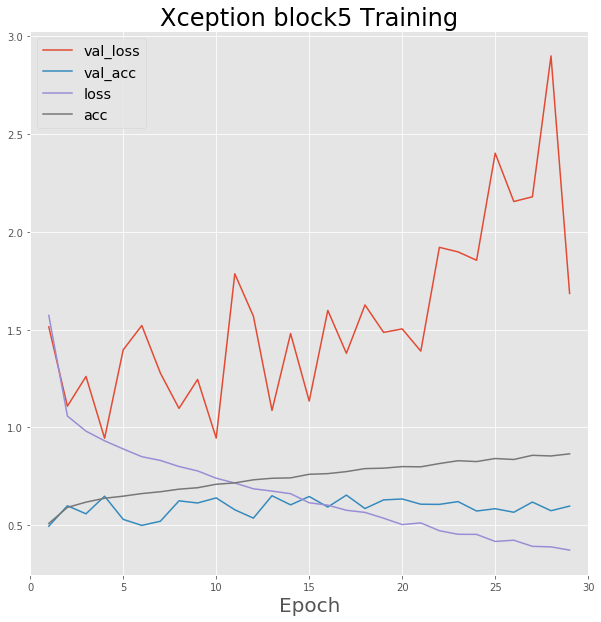

In [10]:
plt.show(models_utils.make_training_fig(history.history,
                      title="Xception block5 Training"))

In [11]:
y_hat = model.predict_generator(val_gen.flow(X_val))
y_hat = np.argmax(y_hat, axis=1)

y_true = np.argmax(y_val, axis=1)

In [12]:
facies_names = ['argilaceous siltstone', 'fossiliferous argilaceous siltstone',
     'siliceous mudstone', 'argilaceous siliceous mudstone', 'calcareous siliceous mudstone',
     'wackestone', 'packstone - grainstone', 'rudstone', 'dolomitic packstone']

cnf_matrix = confusion_matrix(y_true+1, y_hat+1)

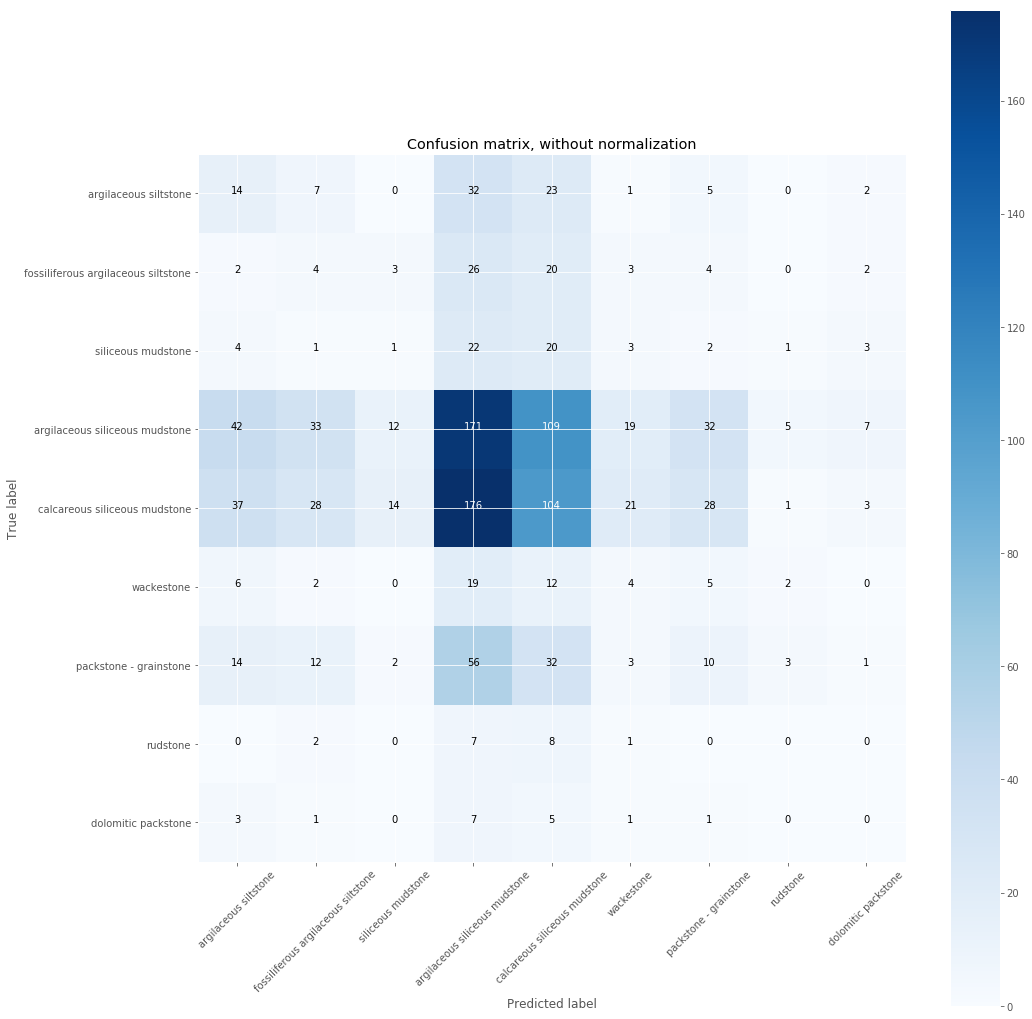

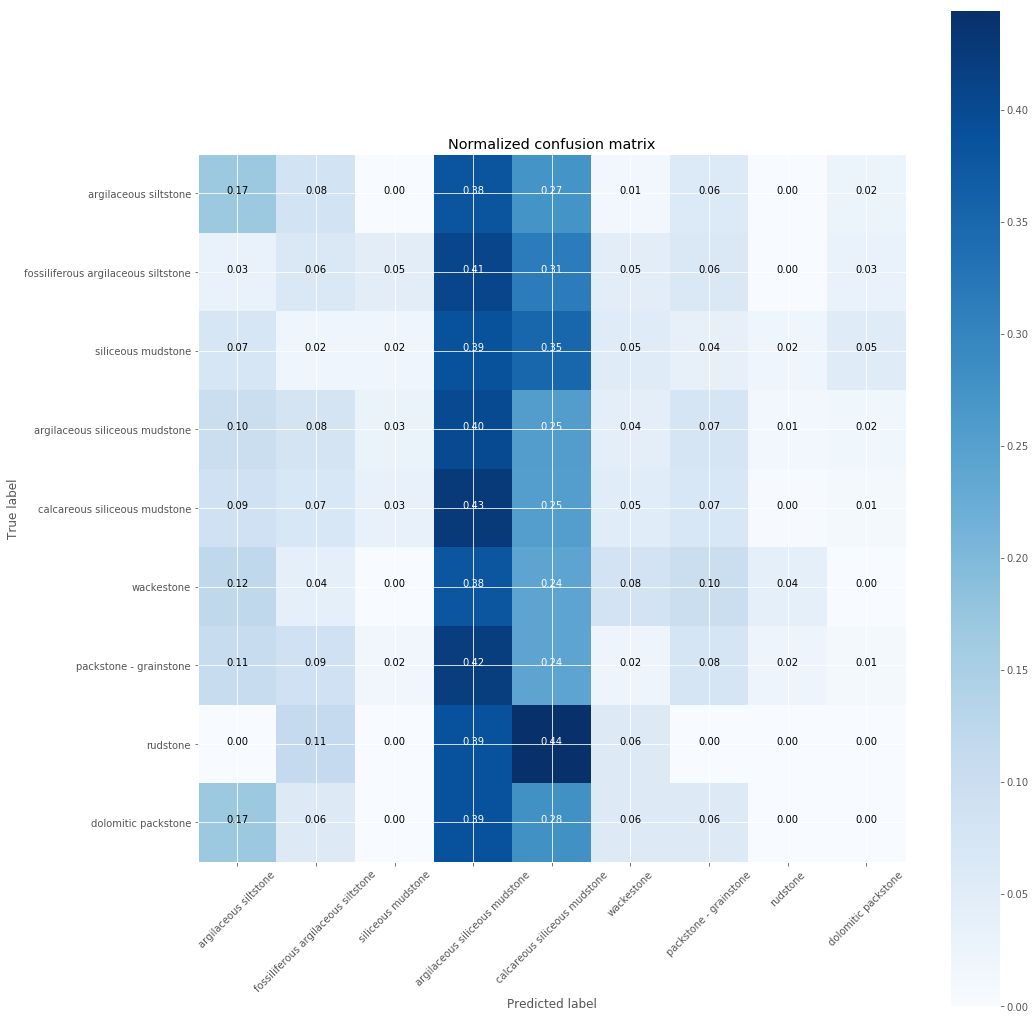

In [13]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [14]:
# Print Validation Accuracy
sum(np.equal(y_true, y_hat)) / y_hat.size

0.24328593996840442

# Now try with class weighting

In [15]:
out_layer = 'block5_sepconv3_act'
model = net_builder.build_conv_model(X_train[0].shape, n_classes, 'xception',
                                    pooling='max', out_layer='block5_sepconv3_act')

rms = optimizers.RMSprop()
model.compile(optimizer=rms,
            loss='categorical_crossentropy',
            metrics=metrics)

CHKPT_PATH = SAVE_DIR+'xception_block5_weighted_best.hdf5'
checkpoint = ModelCheckpoint(CHKPT_PATH, monitor='val_loss', save_best_only=True)

history2 = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train)/batch_size,
                    class_weight = class_weights,
                    validation_data=val_flow,
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[early_stop, checkpoint], verbose=1, epochs=epochs)

model.load_weights(CHKPT_PATH)

Setup base_model:  xception
Using layer  block5_sepconv3_act  as output layer
Epoch 1/500
159/158 [==============================] - 49s 311ms/step - loss: 1.8806 - acc: 0.4914 - val_loss: 1.0833 - val_acc: 0.6051
Epoch 2/500
159/158 [==============================] - 47s 296ms/step - loss: 1.0728 - acc: 0.5849 - val_loss: 1.1214 - val_acc: 0.5513
Epoch 3/500
159/158 [==============================] - 47s 297ms/step - loss: 0.9898 - acc: 0.6125 - val_loss: 1.1271 - val_acc: 0.5632
Epoch 4/500
159/158 [==============================] - 47s 297ms/step - loss: 0.9612 - acc: 0.6210 - val_loss: 1.1059 - val_acc: 0.6311
Epoch 5/500
159/158 [==============================] - 47s 296ms/step - loss: 0.9137 - acc: 0.6445 - val_loss: 1.3208 - val_acc: 0.5284
Epoch 6/500
159/158 [==============================] - 47s 297ms/step - loss: 0.8813 - acc: 0.6567 - val_loss: 1.2419 - val_acc: 0.6161
Epoch 7/500
159/158 [==============================] - 47s 297ms/step - loss: 0.8426 - acc: 0.6684 - val_l

In [16]:
with open('./training_logs/xception_block5_weighted', 'wb') as hist_pickle:
        pickle.dump(history2.history, hist_pickle)

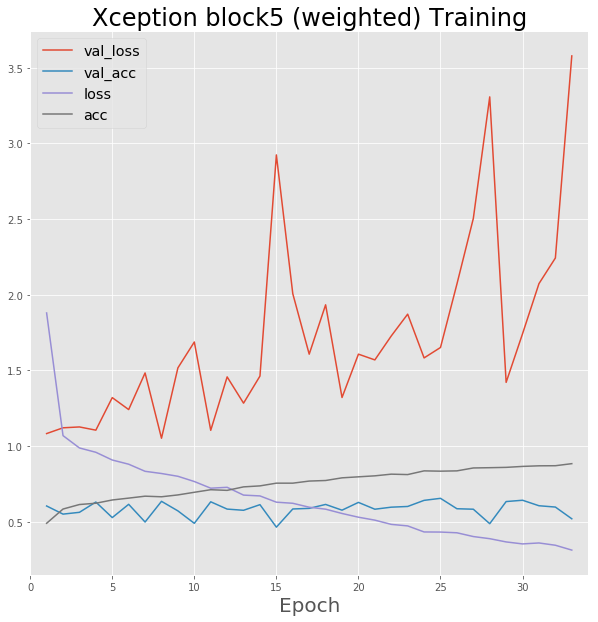

In [17]:
plt.show(models_utils.make_training_fig(history2.history,
                      title="Xception block5 (weighted) Training"))

In [18]:
y_hat = model.predict_generator(val_gen.flow(X_val))
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)

facies_names = ['argilaceous siltstone', 'fossiliferous argilaceous siltstone',
     'siliceous mudstone', 'argilaceous siliceous mudstone', 'calcareous siliceous mudstone',
     'wackestone', 'packstone - grainstone', 'rudstone', 'dolomitic packstone']

cnf_matrix = confusion_matrix(y_true+1, y_hat+1)

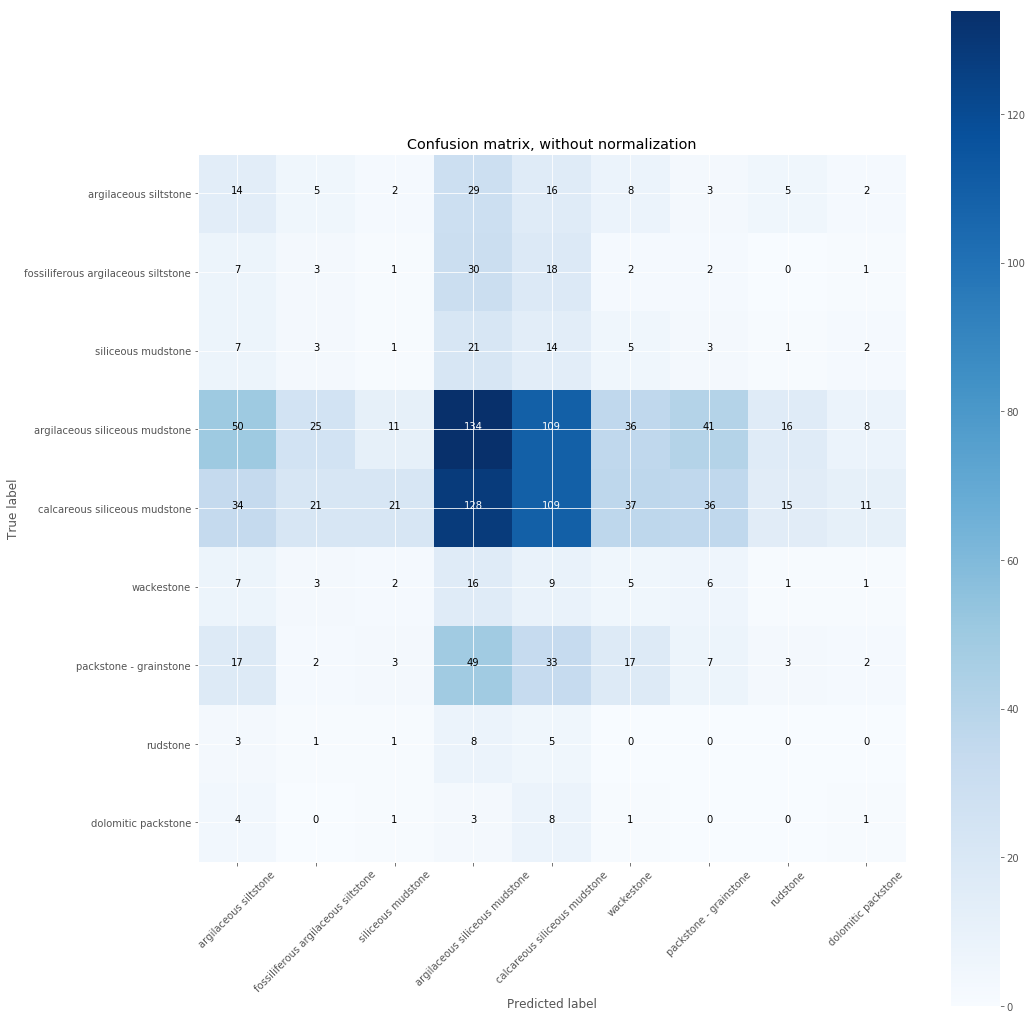

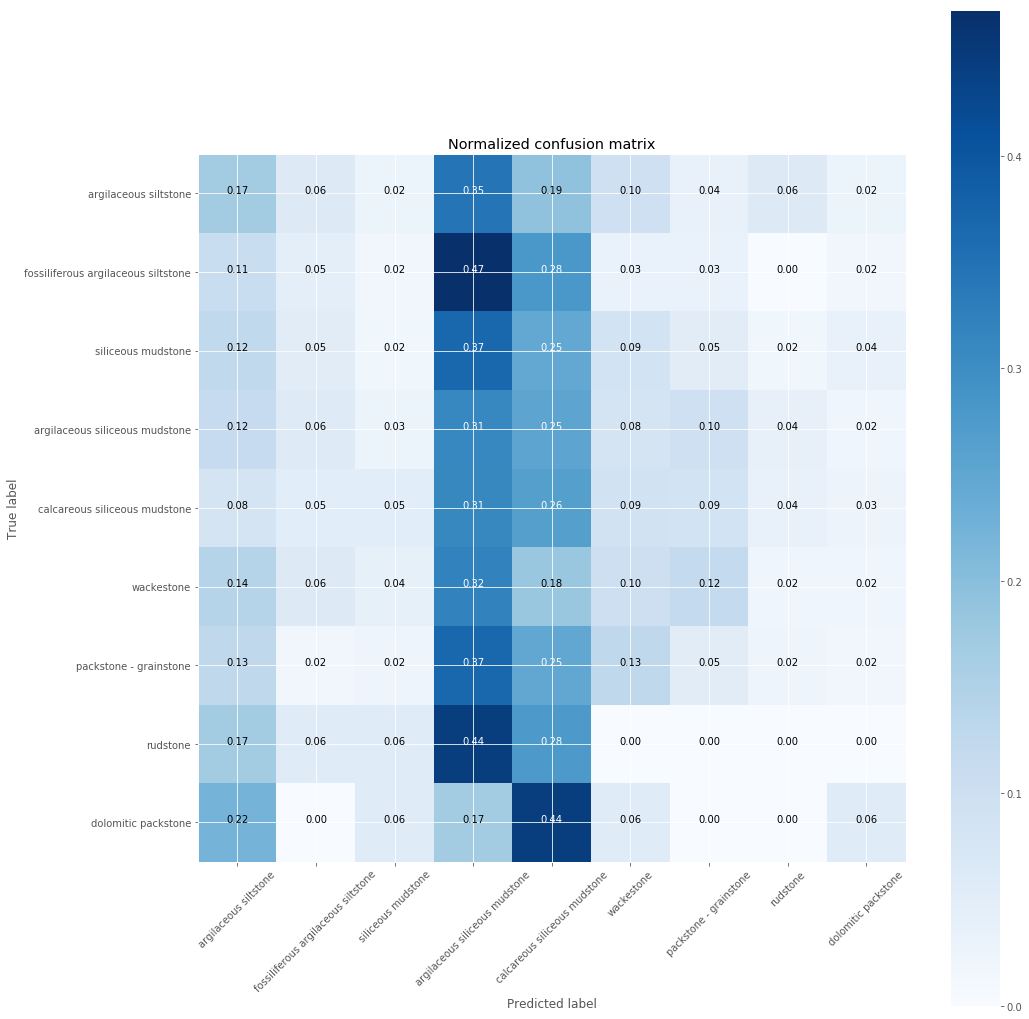

In [19]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()